In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib

def plot_datalimited(keep_ratio, traindata_ratio, 
                              method1_metrics, method2_metrics,
                              method1_name="MM-STGED", method2_name="DTPTrajRec"):
    """
    绘制双方法、多指标的3D柱状图对比，展示不同keep_ratio和traindata_ratio下的性能差异。
    
    参数：
    keep_ratio: 数值列表，第一个变量（Y轴）的取值
    traindata_ratio: 数值列表，第二个变量（X轴）的取值
    method1_metrics: 字典，方法1的5个指标数据，键为指标名（"Acc", "Recall", "Precision", "MAE", "RMSE"），值为数值列表
    method2_metrics: 字典，方法2的5个指标数据，格式同method1_metrics
    method1_name: 字符串，方法1的名称（用于图表标注），默认"MM-STGED"
    method2_name: 字符串，方法2的名称（用于图表标注），默认"DTPTrajRec"

    配色：
    colors = sns.color_palette("coolwarm", n_colors=len(traindata_ratio))
    """
    # 全局设置
    matplotlib.rcParams['font.family'] = 'Times New Roman'
    sns.set(style="white")
    
    # 定义颜色方案（按traindata_ratio数量生成渐变色）
    colors = sns.color_palette("coolwarm", n_colors=len(traindata_ratio))
    
    # ---------------------- 内部辅助函数：创建单个3D柱状图 ----------------------
    def create_3d_bar(ax, data, z_lim, z_ticks, title=""):
        # 转置数据确保维度与X/Y轴匹配
        data = data.T
        # 生成X/Y轴网格（对应traindata_ratio和keep_ratio的索引）
        y, x = np.meshgrid(np.arange(len(keep_ratio)), np.arange(len(traindata_ratio)))
        dx = dy = 1  # 柱子宽度
        
        # 添加底部灰色平面，增强3D层次感
        ax.plot_surface(x, y, np.full_like(data, z_lim[0]), color='gray', alpha=0.3)
        
        # 逐个绘制3D柱子
        for i in range(len(traindata_ratio)):
            for j in range(len(keep_ratio)):
                # 柱子高度 = 数据值 - z轴最小值（确保从z_lim[0]开始向上延伸）
                ax.bar3d(x[i, j], y[i, j], z_lim[0], 
                         dx, dy, data[i, j] - z_lim[0], 
                         color=colors[i], alpha=0.9)
        
        # 轴标签与刻度设置
        ax.set_xticks(np.arange(len(traindata_ratio)) + 0.4)
        ax.set_yticks(np.arange(len(keep_ratio)) + 0.4)
        ax.set_xticklabels(traindata_ratio, fontsize=12, rotation=-30)
        ax.set_yticklabels(keep_ratio, fontsize=12, rotation=6)
        ax.set_xlabel('data_ratio', fontsize=14, labelpad=6)
        ax.set_ylabel('keep_ratio', fontsize=14, labelpad=6)
        ax.tick_params(pad=0)  # 缩短刻度标签与轴的距离
        
        # Z轴范围与刻度（适配不同指标数值范围）
        ax.set_zlim(z_lim)
        ax.set_zticks(z_ticks)
        ax.tick_params(axis='z', labelsize=12)
        
        # 3D视角与网格
        ax.view_init(elev=20, azim=45)  # 固定视角（仰角20°，方位角45°）
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # 子图标题
        ax.set_title(title, fontsize=16)
    
    # ---------------------- 主图表布局：2行5列子图（双方法×5指标） ----------------------
    fig = plt.figure(figsize=(20, 9))
    
    # 指标配置（统一每个指标的Z轴范围与刻度，确保双方法对比一致）
    metric_config = {
        "Acc": {"z_lim": (0.6, 0.9), "z_ticks": np.arange(0.6, 0.91, 0.1)},
        "Recall": {"z_lim": (0.7, 0.9), "z_ticks": np.arange(0.7, 0.91, 0.05)},
        "Precision": {"z_lim": (0.75, 0.9), "z_ticks": np.arange(0.75, 0.91, 0.05)},
        "MAE": {"z_lim": (100, 400), "z_ticks": np.arange(100, 361, 50)},
        "RMSE": {"z_lim": (500, 1100), "z_ticks": np.arange(500, 1001, 100)}
    }
    metrics = ["Acc", "Recall", "Precision", "MAE", "RMSE"]  # 指标顺序
    
    # 第一行：方法1的5个指标子图
    for idx, metric in enumerate(metrics):
        ax = fig.add_subplot(2, 5, idx + 1, projection='3d')
        create_3d_bar(ax, method1_metrics[metric],
                     z_lim=metric_config[metric]["z_lim"],
                     z_ticks=metric_config[metric]["z_ticks"],
                     title=metric)
    
    # 第二行：方法2的5个指标子图（无标题，避免重复）
    for idx, metric in enumerate(metrics):
        ax = fig.add_subplot(2, 5, idx + 6, projection='3d')
        create_3d_bar(ax, method2_metrics[metric],
                     z_lim=metric_config[metric]["z_lim"],
                     z_ticks=metric_config[metric]["z_ticks"],
                     title="")
    
    # ---------------------- 全局格式调整：图例、方法名称标注 ----------------------
    # 调整子图间距
    plt.tight_layout(pad=2.0)
    fig.subplots_adjust(top=0.88, bottom=0.12)
    
    # 图例（对应traindata_ratio的颜色）
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.9) 
               for i in range(len(traindata_ratio))]
    labels = [f'Train Data Ratio: {ratio}' for ratio in traindata_ratio]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), 
               ncol=5, fontsize=15)
    
    # 方法名称标注（位于两行子图中间和底部）
    fig.text(0.5, 0.5, method1_name, ha='center', va='bottom', fontsize=16)
    fig.text(0.5, 0.09, method2_name, ha='center', va='bottom', fontsize=16)
    
    # 保存与显示
    plt.savefig("combined_3d_bars_beautiful.pdf", format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

C:\Users\86198\AppData\Local\Temp\ipykernel_7888\2543145899.py:102: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=2.0)


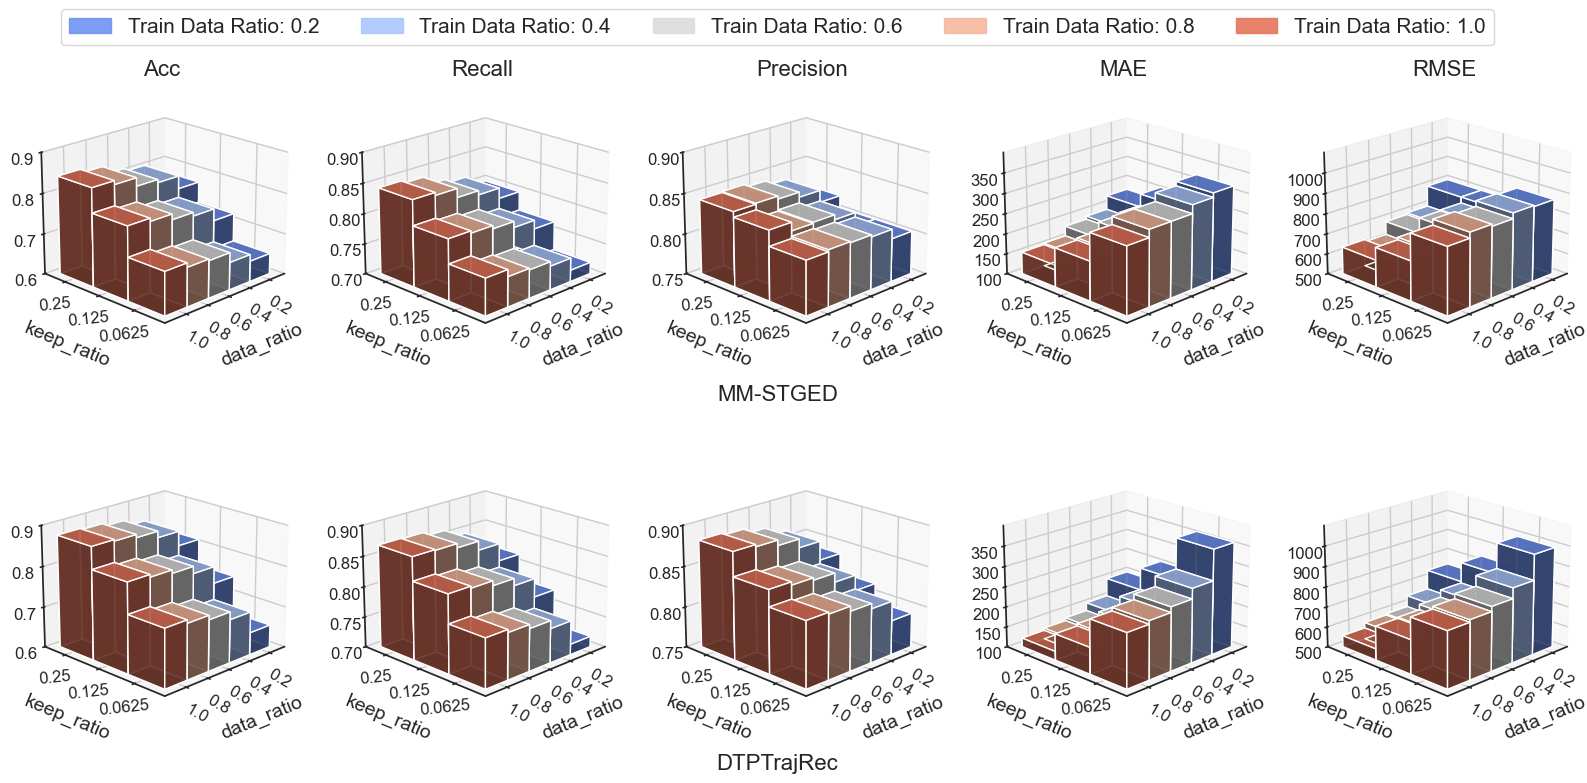

In [17]:
# 1. 输入变量（X/Y轴）
keep_ratio = np.array([0.25, 0.125, 0.0625])
traindata_ratio = np.array([0.2, 0.4, 0.6, 0.8, 1])

# 2. 方法1（MM-STGED）数据
method1_metrics = {
    "Acc": np.array([
        [0.772009927647939, 0.8039033671240737, 0.8118341742355892, 0.8330617245535753, 0.8426],
        [0.720386626082795, 0.7500326501424618, 0.759149998862901, 0.7733221896267962, 0.7814],
        [0.650782169862586, 0.667387855097355, 0.6916379851025132, 0.6956782216723005, 0.7064]
    ]),
    "Recall": np.array([
        [0.7981923047726968, 0.8156294218978426, 0.8226438858477662, 0.837658122387577, 0.8426],
        [0.7665947264604178, 0.7811109578348614, 0.7912837570415604, 0.7967817133133893, 0.8006],
        [0.7188466123913633, 0.7389950889960704, 0.7463266319712505, 0.7487884835399851, 0.7604]
    ]),
    "Precision": np.array([
        [0.8185518527979357, 0.8337764601496739, 0.8401241348989987, 0.8438886788558283, 0.8426],
        [0.8031844057507498, 0.82047599903898, 0.8267120328399377, 0.825359103163901, 0.8358],
        [0.8032358336361922, 0.8149647672598755, 0.8175037542263046, 0.8188736813814567, 0.8163]
    ]),
    "MAE": np.array([
        [225.29302693634227, 190.01058068559564, 182.2241904361159, 157.67037584566282, 154.0],
        [258.7035657220989, 229.67614091434808, 223.41896269074476, 202.48157518773382, 197.2],
        [318.6476106143945, 307.6547620287718, 286.0495162072769, 285.7715192792337, 266.2]
    ]),
    "RMSE": np.array([
        [801.6474277984848, 697.1573074937861, 688.3457528649003, 622.3489372751103, 633.5],
        [802.161932530613, 771.8912019566386, 767.2034403324806, 707.9953857904931, 696.0],
        [870.4862403409147, 876.1066136346094, 847.899709478752, 858.337480937633, 829.7]
    ])
}

# 3. 方法2（DTPTrajRec）数据
method2_metrics = {
    "Acc": np.array([
        [0.8123871633877587, 0.8488860751451073, 0.864944068749885, 0.8727743011866681, 0.8766099503787687],
        [0.7467265033921382, 0.7882134353277958, 0.8061323882541346, 0.8146692394403946, 0.8213657820731323],
        [0.6546534844259644, 0.7062617093518664, 0.7252561055445098, 0.7362134269519246, 0.744630285852712]
    ]),
    "Recall": np.array([
        [0.8163478807526383, 0.845043672760932, 0.8601713499698013, 0.867102265784914, 0.8683350080376329],
        [0.7750412700875658, 0.8056679995515339, 0.8175888905198898, 0.8256284798227979, 0.828992274718438],
        [0.7173082219518294, 0.7562948766608255, 0.7694483750047534, 0.7761718985499982, 0.7812930316586126]
    ]),
    "Precision": np.array([
        [0.8380825141268636, 0.8618710997782553, 0.872899430131143, 0.8796156084500495, 0.8823364218400976],
        [0.8141294608455123, 0.8336000422383949, 0.8448595376054625, 0.8478902517922505, 0.8519759027248143],
        [0.7921878632721119, 0.8164222312189825, 0.8228562994969895, 0.8289931199241043, 0.8312635801005694]
    ]),
    "MAE": np.array([
        [200.22003050312557, 154.7897100546153, 134.5564887931973, 127.41418252462189, 121.69704716573672],
        [256.29802920456984, 201.70407543734277, 181.1814290293348, 170.9319481582377, 165.49730151509937],
        [359.205208919205, 282.48917931390156, 256.62275403955454, 242.8818134912909, 234.2732010884587]
    ]),
    "RMSE": np.array([
        [742.9348808398357, 646.2526443781618, 590.1000488696259, 583.5519306783139, 555.7241923896671],
        [840.0368487743666, 736.529232448086, 700.0533102134623, 673.9245034003995, 668.8123601955884],
        [993.8342046336253, 867.25879735386, 815.0018147990673, 790.2972902974616, 777.8466439742521]
    ])
}

# 调用函数生成图表
plot_datalimited(keep_ratio, traindata_ratio, method1_metrics, method2_metrics, method1_name="MM-STGED", method2_name="DTPTrajRec")